In [ ]:
library(dplyr)
library(ggplot2)

In [11]:
gen.bandits <- function(K, epsilon = c(0.02, .3)) {
    start <- epsilon[1]
    end <- epsilon[2]
    c(.5, .5 - runif(K-1, start, end))
}

event <- function(i, result, K) {
    a <- rep(NaN, K)
    a[i] <- result
    a
}

get.mean <- function(events, optimistic = TRUE) {
    means <- apply(events, 2, mean, na.rm=TRUE)
    if (optimistic) {
        sapply(means, function (x) ifelse(is.nan(x), 1, x))
    }
    else means
}

pull.arm <- function(p) rbinom(1,1,p)

regret <- function(bandits, events) {
    winner <- which.max(bandits)
    top <- bandits[winner]
    n <- dim(events)[1]
    events[is.nan(events)] <- 0
    sapply(1:n, function (i) (i * top - sum(events[1:i,])))
}

epsilon.greedy <- function(events, epsilon) {
    m <- get.mean(events)
    i <- which.max(m)
    if (runif(1) > epsilon) i
    else sample(1:dim(events)[2], 1)
}

runner <- function(K, policy, n) {
    bandits <- gen.bandits(K)
    events <- matrix(nrow=1, ncol=K)
    for (i in 1:n) {
        move <- policy(events)
        result <- pull.arm(bandits[move])
        new.events <- event(move, result, K)
        events <- rbind(events, new.events)
    }
    events <- tail(events, -1) # remove initial
    list(bandits = bandits, events = events, regret = regret(bandits, events))
}

avg.greedy <- function(eps, n=300, m=15) {
    m <- sapply(1:m, function (e) runner(10, function (i) epsilon.greedy(i, eps), n)$regret)
    data.frame(time = 1:n, regret = apply(m, 1, mean))
}

plot.greedys <- function() {
    epsilons <- seq(0.02,0.1,.02)
    df <- data.frame()
    for (e in epsilons){
        df <- rbind(df, avg.greedy(e) %>% mutate(eps = as.factor(e)))
    }
    df %>%
        ggplot(aes(x = time, y = regret, color = eps)) +
        geom_line()
}

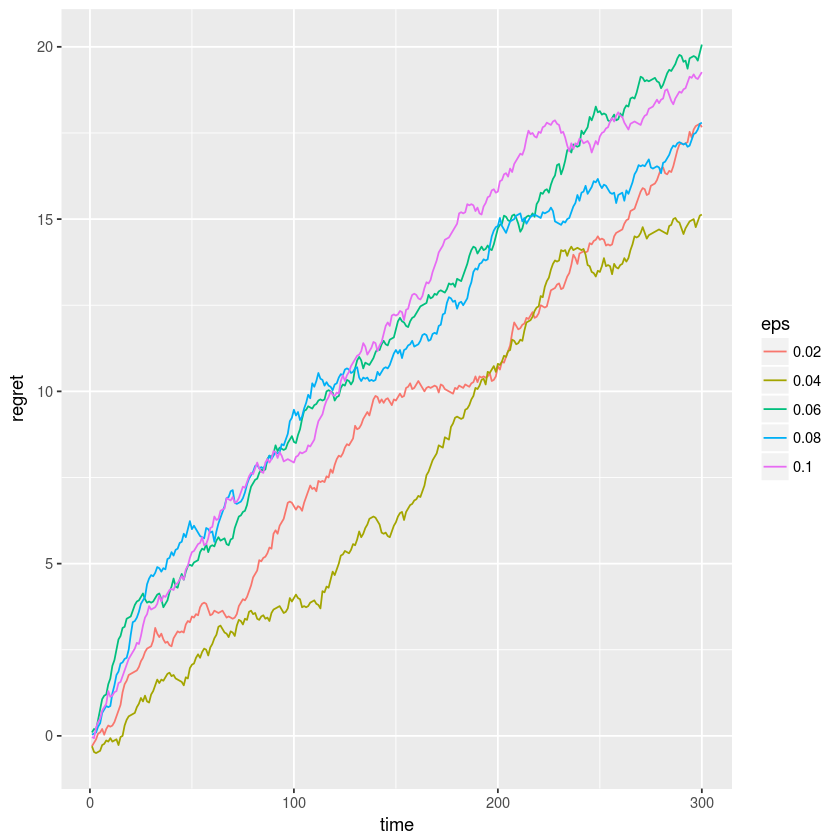

In [13]:
plot.greedys() 